In [1]:
def L8_clustering(site):
    from sklearn.cluster import AgglomerativeClustering
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats
    from thesis_setup import thesis_setup
    import pandas as pd
    
    tower_coordinates,L8_filename,workPath,thesisPath,figurePath,dataPath,L8Path,FluxMapPath,savePath = thesis_setup(site)
    
    satdata = pd.read_csv(L8_filename,delimiter = ',',header = 1)
    

In [97]:
from thesis_setup import thesis_setup
from thesis_setup import getL8Dates
import pandas as pd
import numpy as np

site = 'Young'
tower_coordinates,L8_filename,workPath,thesisPath,figurePath,dataPath,L8Path,FluxMapPath,savePath = thesis_setup(site)

satdata = pd.read_csv(L8Path+'/'+L8_filename,delimiter = ',',header = 1)

In [24]:
def showAllKeys(data):
    # Showing data keys.
    print(f'--ALL DATA KEYS--\n')
    for key in data.keys():
        if isinstance(data[key],dict):
            print(f'Key: {key}\n       {list(data[key].keys())}')
            for subkey in data[key].keys():
                if isinstance(data[key][subkey],dict):
                    print(f'        keys:\n          {subkey}: {list(data[key][subkey].keys())}')
        else:
            print(f'Key: {key}')
showAllKeys(satdata)

--ALL DATA KEYS--

Key: 0
Key: MNDWI_SW1
Key: MNDWI_SW2
Key: NDVI
Key: NDWI
Key: CELSIUS
Key: id
Key: latitude
Key: longitude
Key: time
Key: {"geodesic":false,"type":"Polygon","coordinates":[[[-100.20792448095982,50.3589555487188],[-100.19541465811436,50.3589555487188],[-100.19541465811436,50.365758730391555],[-100.20792448095982,50.365758730391555],[-100.20792448095982,50.3589555487188]]]}


In [32]:
getL8Dates('Young')

Landsat 8 dates for Young (59 total images):

2021 (20): 
[20210527 20210605 20210612 20210621 20210628 20210707 20210714 20210723
 20210730 20210808 20210815 20210831 20210909 20210916 20210925 20211002
 20211011 20211018 20211103 20211230]

2022 (32): 
[20220106 20220207 20220216 20220223 20220311 20220320 20220327 20220421
 20220428 20220507 20220523 20220608 20220615 20220701 20220710 20220717
 20220726 20220802 20220811 20220818 20220827 20220903 20220912 20220928
 20221005 20221014 20221021 20221030 20221122 20221201 20221217 20221224]

2023 (7): 
[20230102 20230118 20230210 20230219 20230307 20230323 20230330]


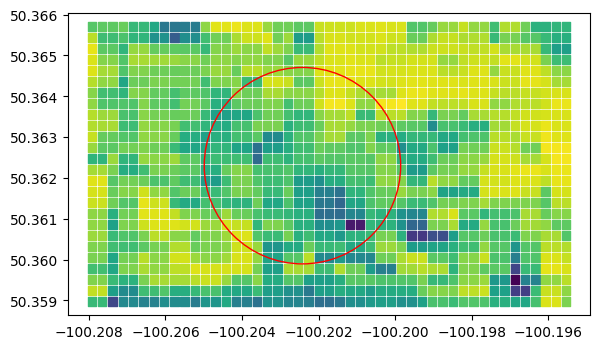

In [115]:
import matplotlib.pyplot as plt
satdata['id']
get_date = '20220717'
# get_date = str(L8_dates[3])
date_idx = [idx for idx,date in enumerate([id_date[12:] for id_date in satdata['id']]) if date==get_date]
this_sat = satdata['id'][date_idx]

this_sat = {key: [satdata[key][index] for index in date_idx] for key in satdata}

plt.figure(figsize = (6.1,3.6))
plt.scatter(this_sat['longitude'],this_sat['latitude'],c=this_sat['NDVI'],marker='s')
plt.scatter(tower_coordinates[0],tower_coordinates[1],marker='o',facecolors='none', edgecolors='r',s=20000)
plt.tight_layout()

In [99]:
from thesis import preprocess_maps
import os
def get_last_number(item):
    return int(item.split('L8=')[1].split('.')[0])

file_names = [file_name for file_name in os.listdir(dataPath+'/Compilation/'+site+'_Annual') if '.p' in file_name]
file_names = sorted(file_names,key=get_last_number)
ffp_names = [file.split('=')[1].split('_L8')[0] for file in file_names]
L8_dates = [int(file.split('L8=')[1].split('.')[0]) for file in file_names]


In [132]:
np.array(file_names)[wanted_indices]

array(['Young_FFP=202106029-202107029_L8=20210714.p',
       'Young_FFP=202107024-202108023_L8=20210808.p',
       'Young_FFP=202108016-202109015_L8=20210831.p',
       'Young_FFP=202108025-202109024_L8=20210909.p',
       'Young_FFP=202109010-202110010_L8=20210925.p',
       'Young_FFP=202109017-202110017_L8=20211002.p',
       'Young_FFP=202109026-202110026_L8=20211011.p',
       'Young_FFP=202110003-202111002_L8=20211018.p',
       'Young_FFP=202110019-202111018_L8=20211103.p'], dtype='<U43')

In [156]:
# Cluster L8
from sklearn.cluster import AgglomerativeClustering
wanted_year = '2021'
wanted_indices = [index for index,file in enumerate(file_names) if file in [year for year in file_names if year.split('L8=')[1][:4] ==wanted_year]]

process_files = np.array(file_names)[wanted_indices]
process_ffp = np.array(ffp_names)[wanted_indices]
process_L8 = np.array(L8_dates)[wanted_indices]

N = len(process_files)
# plt.figure(figsize=(14,2.6*N))
# fig, ax = plt.subplots(N,4,figsize = (14,2.6*N))
site = 'Young'
cluster_index = 'NDVI'
n_clusters = 5
indexes = ['NDWI','NDMI','NDVI','temp']

# Storing all runs into single dict, while keeping runs separate
collected_regression = {'period':[],'r_val':[],'p_val':[],
                        'landsat':[],'ffp':[]}

collapsed_regression = {'slope':[],'offset':[],'r_val':[],'p_val':[]}

# Collapsing all runs into single analysis
collapsed_landsat = {'NDWI':[],'NDMI':[],'NDVI':[],'temp':[],'period':[]}
collapsed_ffp = []

# Storing all linear equation data:
yfit = {'slope': [],'offset':[]}

for ii, date in enumerate(process_L8):
    print(f'Stage: {ii}/{len(process_L8)} - ',end='')
    data = preprocess_maps('Young',process_ffp[ii],date,FluxMapPath+'/compilation/'+site)

    dend_data = np.transpose([data['landsat'][cluster_index],data['landsat'][cluster_index]])

    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')

    cn_PC = cluster.fit_predict(dend_data)
    #find mean pattern of each cluster
    cluster_pattern_PC = np.empty((n_clusters,np.shape(dend_data)[1]))

    # For 2 clusters
    for cluster_num in range(n_clusters):
        inds_PC = np.argwhere(cn_PC==cluster_num)
        cluster_pattern_PC[cluster_num,:] = np.mean(dend_data[inds_PC,:],axis=0)

    # Compiling clustered data into dicts.
    clustered_ffp = {}
    clustered_landsat = {}
    for clus_idx in range(n_clusters):
        clus_num = np.where(cn_PC == clus_idx)[0]
        clustered_ffp[f'xr_{clus_idx+1}'] = np.array(data['matched_ffp']['xr'])[clus_num]
        clustered_ffp[f'yr_{clus_idx+1}'] = np.array(data['matched_ffp']['yr'])[clus_num]
        clustered_ffp[f'ch4_{clus_idx+1}'] = np.array(data['matched_ffp']['ch4'])[clus_num]
        clustered_landsat[f'NDVI_{clus_idx+1}'] = np.array(data['landsat']['NDVI'])[clus_num]
        clustered_landsat[f'NDWI_{clus_idx+1}'] = np.array(data['landsat']['NDWI'])[clus_num]
        clustered_landsat[f'NDMI_{clus_idx+1}'] = np.array(data['landsat']['NDMI'])[clus_num]
        clustered_landsat[f'MNDWI2_{clus_idx+1}'] = np.array(data['landsat']['MNDWI2'])[clus_num]
        clustered_landsat[f'temp_{clus_idx+1}'] = np.array(data['landsat']['temp'])[clus_num]
    mean_clustered_ffp = []
    mean_clustered_landsat = {'NDVI':[],'NDWI':[],'NDMI':[],'MNDWI2':[],'temp':[]}
    
    for i in range(n_clusters):
        mean_clustered_ffp.append(np.mean(clustered_ffp[f'ch4_{i+1}']))
        for idx,key in enumerate(data['spatialData']):
            mean_clustered_landsat[key].append(np.mean(clustered_landsat[f'{key}_{i+1}']))

    collected_regression['landsat'].append(mean_clustered_landsat)
    collected_regression['ffp'].append(mean_clustered_ffp)
    collected_regression['period'].append([process_ffp[ii],date])
            
#     for i,index in enumerate(indexes):
# #         plt.subplot(N,4,i+ii+1)
#         x_data = mean_clustered_landsat[index]
#         y_data = mean_clustered_ffp
#         ax[ii][i].scatter(x_data,y_data, label = str(date))
#         m,b = np.polyfit(x_data,y_data,1)
#         yfit = np.array(x_data)*m+b
#         ax[ii][i].plot(x_data,yfit,c='orange',alpha=0.5)
#         ax[ii][i].set_title(index)
#         ax[ii][i].legend()
# fig.tight_layout()
# print(f'Finished!')

Stage: 0/9 - Beginning resolution matching: /471
0%..10%..21%..31%..42%..53%..63%..74%..84%..95%..DONE
Stage: 1/9 - Beginning resolution matching: /483
0%..10%..20%..31%..41%..51%..62%..72%..82%..93%..DONE
Stage: 2/9 - Beginning resolution matching: /466
0%..10%..21%..32%..42%..53%..64%..75%..85%..96%..DONE
Stage: 3/9 - Beginning resolution matching: /478
0%..10%..20%..31%..41%..52%..62%..73%..83%..94%..DONE
Stage: 4/9 - Beginning resolution matching: /507
0%..9%..19%..29%..39%..49%..59%..69%..78%..88%..98%..DONE
Stage: 5/9 - Beginning resolution matching: /534
0%..9%..18%..28%..37%..46%..56%..65%..74%..84%..93%..DONE
Stage: 6/9 - Beginning resolution matching: /612
0%..8%..16%..24%..32%..40%..49%..57%..65%..73%..81%..89%..98%..DONE
Stage: 7/9 - Beginning resolution matching: /701
0%..7%..14%..21%..28%..35%..42%..49%..57%..64%..71%..78%..85%..92%..99%..DONE
Stage: 8/9 - Beginning resolution matching: /489
0%..10%..20%..30%..40%..51%..61%..71%..81%..92%..DONE


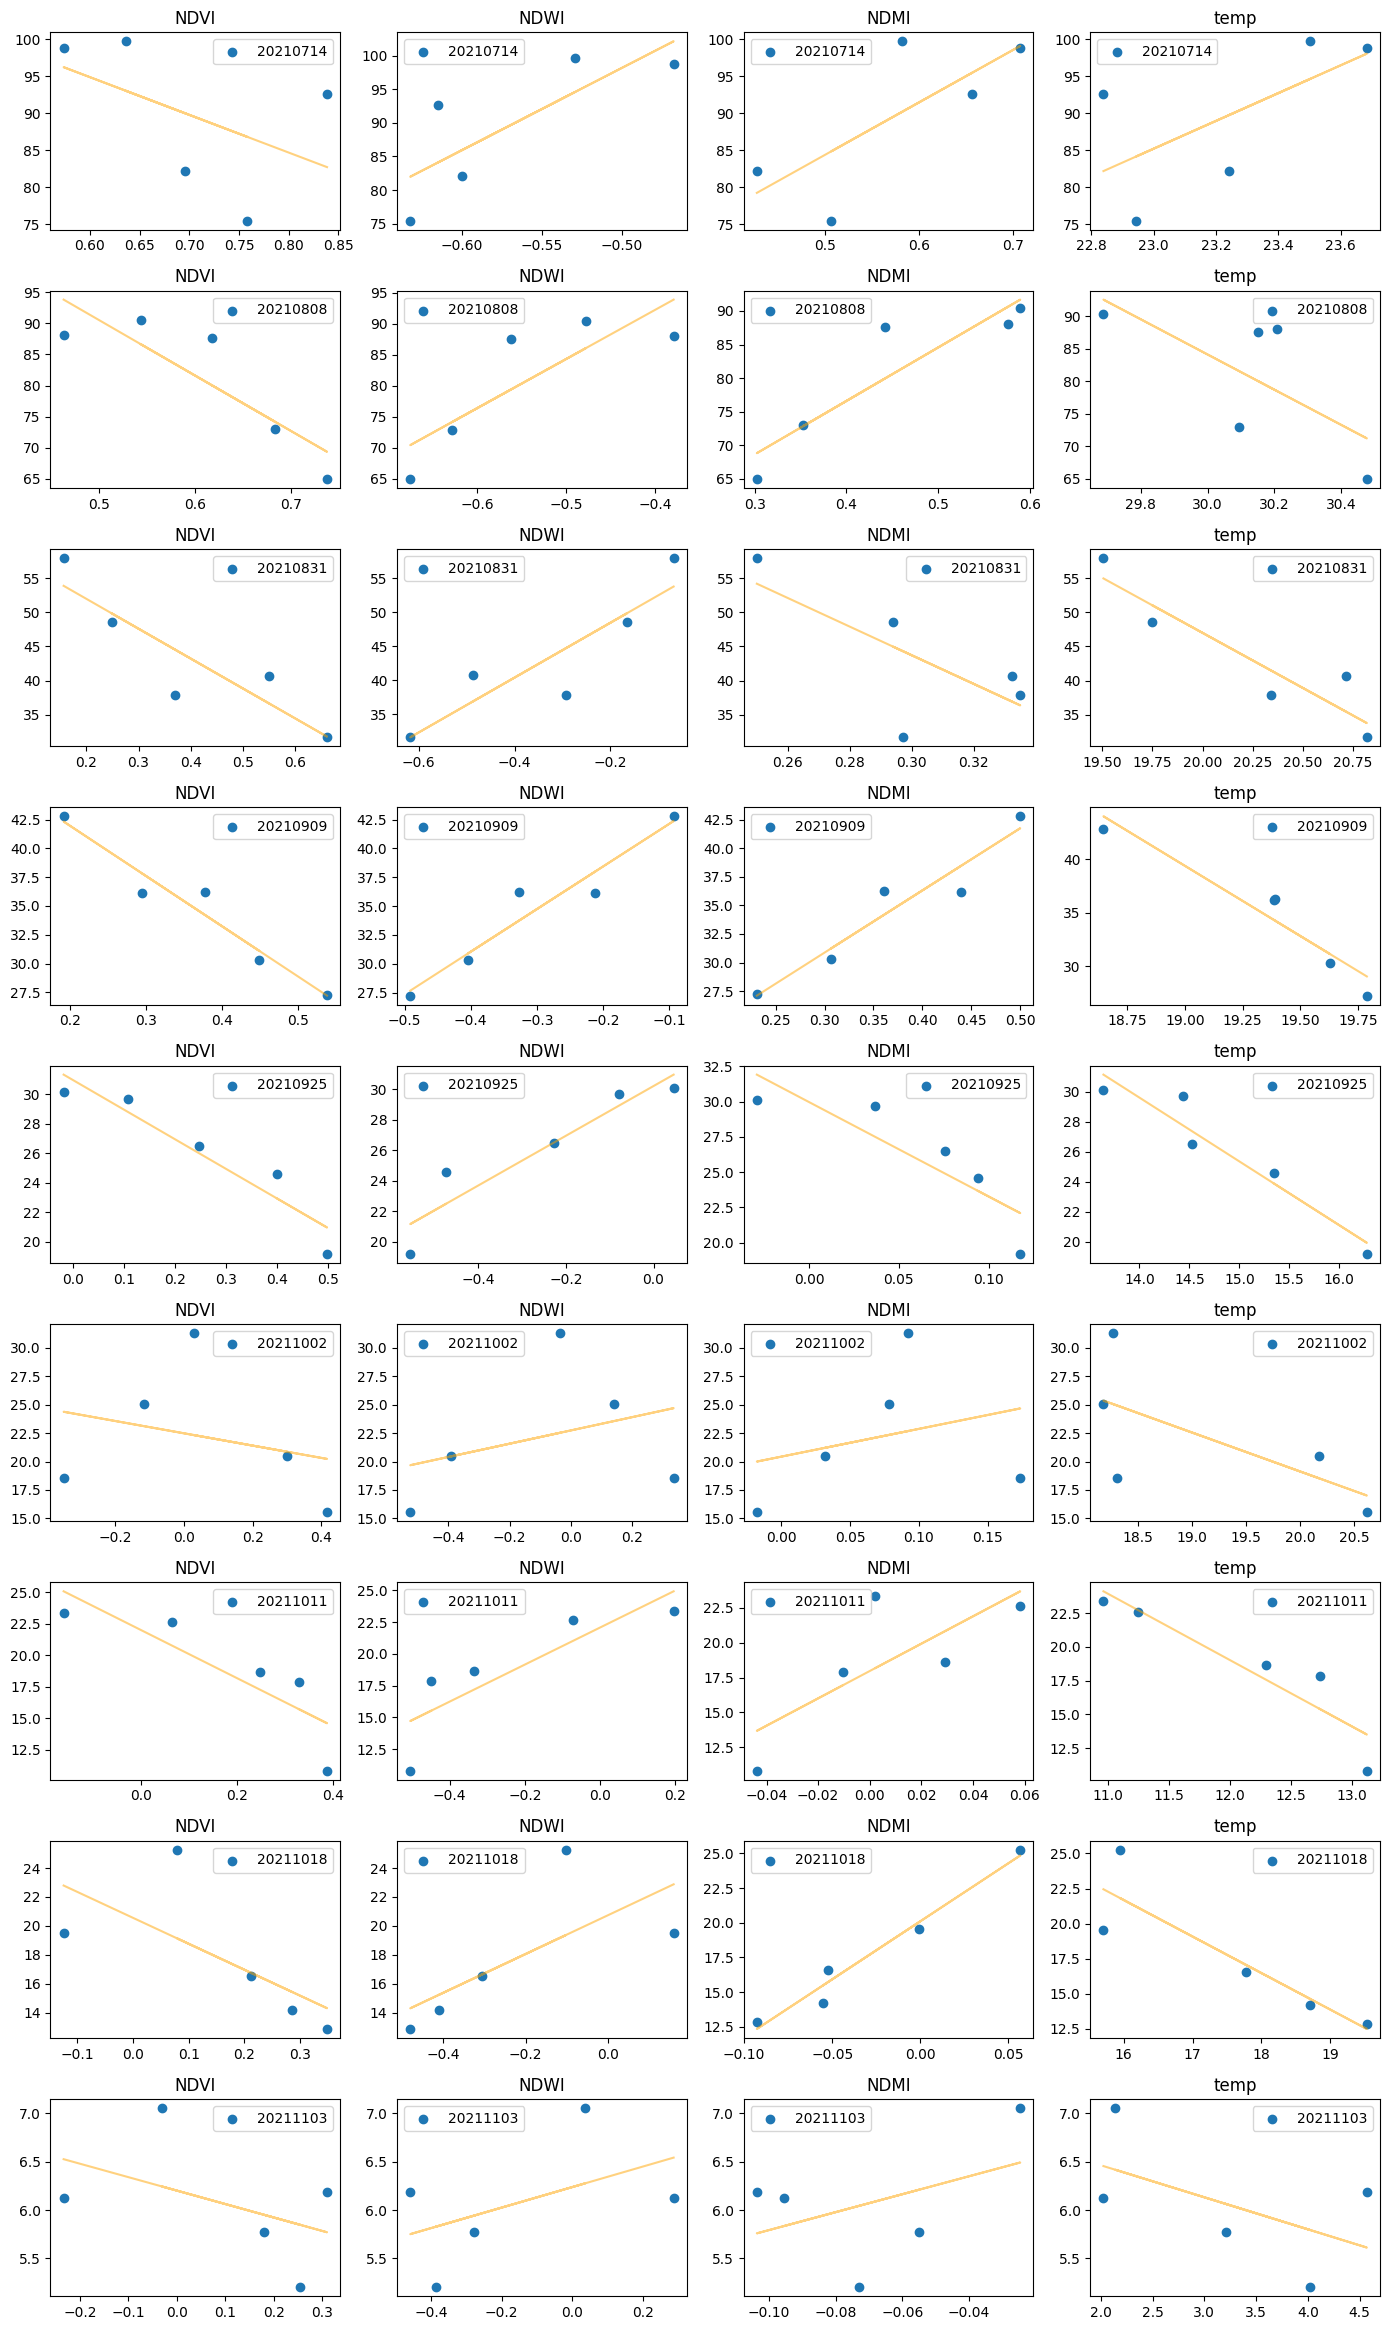

In [166]:
N = len(collected_regression['period'])
fig, ax = plt.subplots(N,4,figsize = (14,2.6*N))

indexes = ['NDVI','NDWI','NDMI','temp']

for ii in range(N):
    y_data = collected_regression['ffp'][ii]
    for i,index in enumerate(indexes):
        x_data = collected_regression['landsat'][ii][index]
        ax[ii][i].scatter(x_data,y_data,label = collected_regression['period'][ii][1])
        m,b = np.polyfit(x_data,y_data,1)
        yfit = np.array(x_data)*m+b
        ax[ii][i].plot(x_data,yfit,c='orange',alpha=0.5)
        ax[ii][i].set_title(index)
        ax[ii][i].legend()
fig.tight_layout()

In [205]:
NDVI_clustered = {'NDVI':[],'NDWI':[],'NDMI':[],'temp':[],'CH4':[],'period':[]}
for i in range(len(collected_regression['period'])):
    for index in indexes:
        for clus in range(5):
            NDVI_clustered[index].append(collected_regression['landsat'][i][index][clus])
    for clus in range(5):
        NDVI_clustered['CH4'].append(collected_regression['ffp'][i][clus])
        NDVI_clustered['period'].append(collected_regression['period'][i][1])
NDVI_clustered['month'] = [int(str(period)[4:6]) for period in NDVI_clustered['period']]


In [206]:
import pickle
save_filename = 'NDVI_clustered'
with open(dataPath+'/Compilation/'+site+'_Annual/2021_growing_season/'+save_filename+'.p', 'wb') as fp:
        pickle.dump(NDVI_clustered, fp, protocol=pickle.HIGHEST_PROTOCOL)

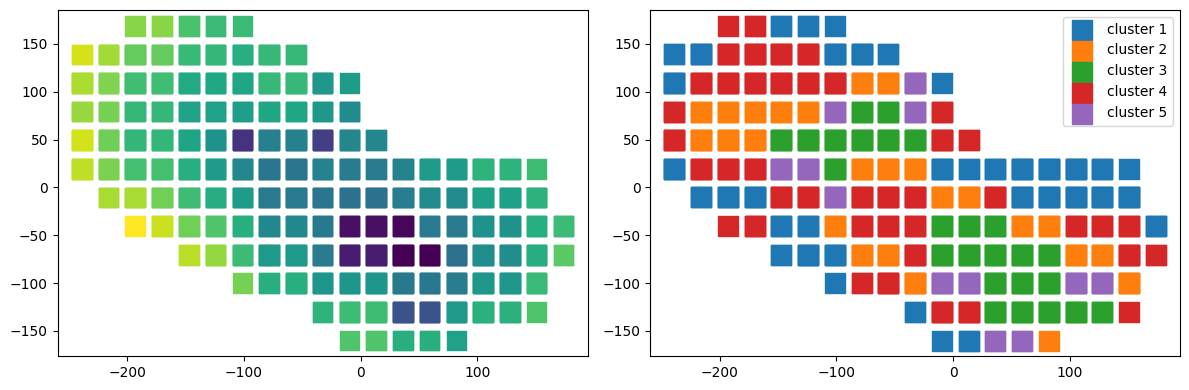

In [79]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(landsat['lonData'],landsat['latData'],c=landsat['temp'],marker='s',s=200)

plt.subplot(1,2,2)
for i in range(len(np.unique(cn_PC))):
    clus_num = np.where(cn_PC==i)[0]
    plt.scatter(np.array(landsat['lonData'])[clus_num],np.array(landsat['latData'])[clus_num],label=f'cluster {i+1}',marker = 's',s=200)
plt.legend()    
plt.tight_layout()

In [118]:
fig.savefig(dataPath+'/Compilation/Young_Annual/NDVI_clustered.png')

In [134]:
data['spatialData']

{'MNDWI2': array([0.27972769, 0.27972769, 0.13921549, ..., 0.20203277, 0.19318849,
        0.19318849]),
 'NDMI': array([0.33399145, 0.33399145, 0.15921075, ..., 0.66801307, 0.77560895,
        0.77560895]),
 'NDVI': array([0.65363938, 0.65363938, 0.433438  , ..., 0.67059486, 0.74309841,
        0.74309841]),
 'NDWI': array([-0.60030814, -0.60030814, -0.44033916, ..., -0.47484472,
        -0.49506416, -0.49506416]),
 'temp': array([24.63676046, 24.63676046, 25.32957202, ..., 22.49474067,
        22.39453446, 22.39453446])}